In [1]:
from pystac_client import Client
from pystac.extensions.eo import EOExtension as eo
import planetary_computer as pc

In [2]:
import geopandas as gpd

/home/edgar/anaconda3/envs/geo_env/lib/python3.8/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.10.1-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  warnings.warn(


In [3]:
gdf = gpd.read_file('../data/external/Area_Estudio/Area_Elevaciones_v2.geojson')
gdf

,geometry
0,"POLYGON ((-103.47743 20.63258, -103.47630 20.6..."


In [4]:
# Reads mun_gdf GeoDataFrame as polygon
poly = gdf.geometry
# Extracts coordinates from polygon as DataFrame
coord_val = poly.bounds
# Gets coordinates for bounding box
n = coord_val.maxy.max()
s = coord_val.miny.min()
e = coord_val.maxx.max()
w = coord_val.minx.min()

In [5]:
n = 20.742277
s = 20.611211
e = -103.262616
w = -103.407605

In [6]:
area_of_interest = {
    "type": "Polygon",
    "coordinates": [
        [
            [e, s],
            [w, s],
            [w, n],
            [e, n],
            [e, s],
        ]
    ],
}

In [14]:
time_of_interest = "2021-05-01/2021-10-31"

In [15]:
catalog = Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")

search = catalog.search(
    collections=["landsat-8-c2-l2"],
    intersects=area_of_interest,
    datetime=time_of_interest,
    query={"eo:cloud_cover": {"lt": 10}},
)

# Check how many items were returned
items = list(search.get_items())
print(f"Returned {len(items)} Items")

Returned 1 Items


In [16]:
selected_item = sorted(items, key=lambda item: eo.ext(item).cloud_cover)[0]

print(
    f"Choosing {selected_item.id} from {selected_item.datetime.date()}"
    + f" with {selected_item.properties['eo:cloud_cover']}% cloud cover"
)

Choosing LC08_L2SP_029046_20210616_02_T1 from 2021-06-16 with 7.02% cloud cover


In [17]:
def find_asset_by_band_common_name(item, common_name):
    for asset in item.assets.values():
        asset_bands = eo.ext(asset).bands
        if asset_bands and asset_bands[0].common_name == common_name:
            return asset
    raise KeyError(f"{common_name} band not found")

In [18]:
asset_hrefs = [
    find_asset_by_band_common_name(selected_item, "red").href,
    find_asset_by_band_common_name(selected_item, "green").href,
    find_asset_by_band_common_name(selected_item, "blue").href,
]

In [19]:
signed_hrefs = [pc.sign(asset_href) for asset_href in asset_hrefs]

In [20]:
import rasterio
from rasterio import windows
from rasterio import features
from rasterio import warp

import numpy as np
from PIL import Image


def read_band(href):
    with rasterio.open(href) as ds:
        aoi_bounds = features.bounds(area_of_interest)
        warped_aoi_bounds = warp.transform_bounds("epsg:4326", ds.crs, *aoi_bounds)
        aoi_window = windows.from_bounds(transform=ds.transform, *warped_aoi_bounds)
        return ds.read(1, window=aoi_window)

In [21]:
bands = [read_band(href) for href in signed_hrefs]

In [22]:
multiband_data = np.stack(bands)

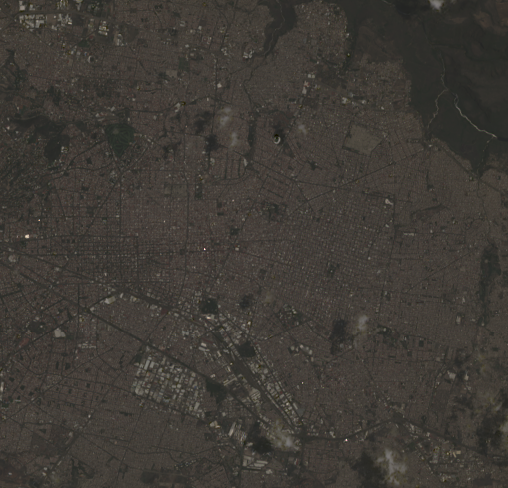

In [23]:
rescaled = multiband_data.astype(float)
min_value, max_value = rescaled.min(), rescaled.max()
rescaled = ((rescaled - min_value) * 255) / (max_value - min_value)
byte_data = rescaled.astype("ubyte")
Image.fromarray(np.transpose(byte_data, axes=[1, 2, 0]))

In [24]:
r = read_band(
    pc.sign(find_asset_by_band_common_name(selected_item, "red").href)
).astype(float)

nir = read_band(
    pc.sign(find_asset_by_band_common_name(selected_item, "nir08").href)
).astype(float)

ndvi = (nir - r) / (nir + r)
w = ndvi.shape[0]
h = ndvi.shape[1]

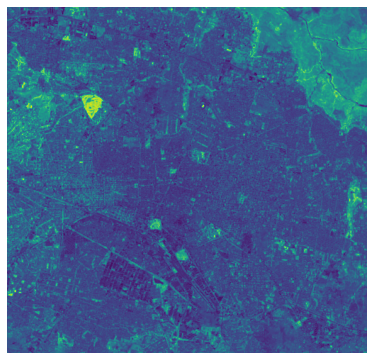

In [25]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

dpi = 150
fig = figure(figsize=(5,5), frameon=False)
ax = plt.Axes(fig, [0.0, 0.0, 1.0, 1.0])
ax.set_axis_off()
fig.add_axes(ax)

plt.imshow(ndvi, cmap="viridis")
#plt.legend(ndvi)

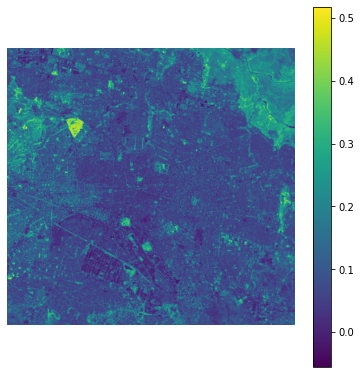

In [26]:
import matplotlib as mpl

dpi = 150
fig = figure(figsize=(5,5), frameon=False)
ax = plt.Axes(fig, [0.0, 0.0, 1.0, 1.0])
ax.set_axis_off()
fig.add_axes(ax)

plt.imshow(ndvi, cmap="viridis")


#Sets boundaries for color ramp
bounds = [-0.3, 0.0,0.6]

#Gets axes
cax, kw = mpl.colorbar.make_axes(plt.gca())

#Normalizes values of color ramp
norm = mpl.colors.Normalize(vmin = ndvi.min(), vmax = ndvi.max(), clip = False)

#Draws color bar with color ramp legend
mpl.colorbar.ColorbarBase(cax, cmap=mpl.cm.viridis, norm=norm)

In [27]:
ndvi.mean()

0.10650350486096977

In [28]:
ndvi.max()

0.5177322930388084

In [29]:
ndvi.min()

-0.05527070887624065

In [32]:
ndvi_2 = ndvi.copy()
ndvi_2[ndvi<=0.1] = np.nan

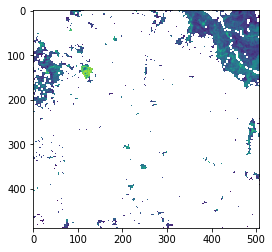

In [33]:
plt.imshow(ndvi_2, cmap="viridis")